In [1]:
import os
import sys
import boto3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from dotenv import load_dotenv
from datetime import datetime

# defining functions module path
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import connect_to_redshift, normalize

In [2]:
# removing warning messages
warnings.filterwarnings("ignore")

In [3]:
# Loading my .env file
load_dotenv()

True

In [4]:
# defining redshift credentials
dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

In [5]:
# establishing redshift connection
rs_connection = connect_to_redshift(dbname, host, port, user, password)

connection to redshift made


In [6]:
query = """select *
           from bootcamp.online_transactions_fixed
        """

In [7]:
ot = pd.read_sql(query, rs_connection)

#### From the data exploration is known that:
- There are 34 transactions with price = 0. These are gonna be removed because they represent just 0.01% of the total data
- There are some transactions with quantity < 0. I divided these transactions on two categories: Transactions with returns on the time interval of the dataset and Returns with the corresponding order outside the time interval of the dataset. Both sets are gonna be removed from the dataset and are gonna be stored in different dataframes to be analyze separately.
- 
### I will perform a customer segmentation considering just the transactions without any return. Therefore, I will create two new datasets. The first one excluding the returned transactions and the second one with just the returned transactions.

In [8]:
# dropping transactions with price = 0
ot.drop(ot[ot['price'] == 0].index, axis=0, inplace=True)
ot.reset_index(inplace=True, drop=True)

In [9]:
# Grouping the data by customer and stock code to get the transactions with their returns
invoice_list = ot.groupby(['customer_id', 'stock_code']).agg({'invoice': list, 'quantity': 'sum'})
invoice_list = invoice_list[ot.groupby(['customer_id', 'stock_code'])['quantity'].sum() <= 0].reset_index()

In [10]:
invoice_idx = []
[invoice_idx.extend(ids) for ids in invoice_list['invoice']];

In [11]:
# Assigning returns whose order is inside the time interval of the dataset
returns = ot[ot['invoice'].isin(invoice_idx)]

In [12]:
# Dataset without returns with order is inside the time interval of the dataset
online_trans = ot.drop(returns.index, axis=0).reset_index()

In [13]:
print(f"{round((ot.shape[0] - online_trans.shape[0]) * 100 / ot.shape[0], 2)} % are returns whose transaction were made in the time interval of the data")

7.56 % are returns whose transaction were made in the time interval of the data


In [14]:
# Let's check the general overview of the data
online_trans.describe()

,index,quantity,price,total_order_value
count,369581.000000,369581.000000,369581.000000,369581.000000
mean,201288.338513,12.594002,2.920241,21.381545
std,115599.335858,43.843466,7.391403,95.916320
min,0.000000,-1515.000000,0.001000,-2432.700000
25%,101108.000000,2.000000,1.250000,4.550000
50%,202244.000000,6.000000,1.950000,11.800000
75%,301164.000000,12.000000,3.750000,19.800000
max,399806.000000,4800.000000,1599.260000,38970.000000


#### There are still some values with quantity (therefore total_order_value) smaller than zero. These transactions represent the returns with corresponding order outside the time window of the dataset. They are gonna be removed from the online_trans dataset and placed in a separate dataframe

In [15]:
# The negative values on the remaining data are considered return whose transactions were done outside the time interval of the data
retunr_wt_trans = online_trans[online_trans['quantity']<= 0]

#### The negative values on the remaining data are considered return whose transactions were done outside the time interval of the data

In [16]:
print(f"{round(retunr_wt_trans.shape[0] * 100 / ot.shape[0], 2)}% are returns without equivalent transaction on the time interval of the data")

1.1% are returns without equivalent transaction on the time interval of the data


In [17]:
# Dropping returned data without transaction on the time interval of the dataframe
online_trans.drop(retunr_wt_trans.index, axis=0, inplace=True)

In [18]:
# Changing the name of the index column to stress that it is the index of the data with returns
online_trans.rename(columns={'index': 'old_index'}, inplace=True)

### The online_trans is gonna be the data that I will use for the customer segmentation analyis. Let's make an deep dive into the data to get to know it better

In [19]:
# Checking numerical variables
online_trans.describe()

,old_index,quantity,price,total_order_value
count,365180.000000,365180.000000,365180.000000,365180.000000
mean,201388.233230,12.879829,2.905252,21.919158
std,115651.048694,43.577928,7.381186,95.735167
min,0.000000,1.000000,0.001000,0.000000
25%,101147.750000,2.000000,1.250000,4.950000
50%,202427.500000,6.000000,1.950000,11.900000
75%,301305.250000,12.000000,3.750000,19.800000
max,399806.000000,4800.000000,1599.260000,38970.000000


In [20]:
# There are some values with total_order_value = 0
online_trans[online_trans["total_order_value"] == 0]

,old_index,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,total_order_value
71381,78296,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,u13952,United Kingdom,0.0
148851,162836,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 14:58:00,0.001,u16198,United Kingdom,0.0
268717,292093,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,u15618,United Kingdom,0.0


### I will replace the total_order_value column coming from the reshift data base by the total order value calculated by myself and round it to 3 decimal points in order to avoid the zero entries that we see in the cell above

In [21]:
online_trans['total_order_value'] = online_trans['price'] * online_trans['quantity']

### Let's check outliers

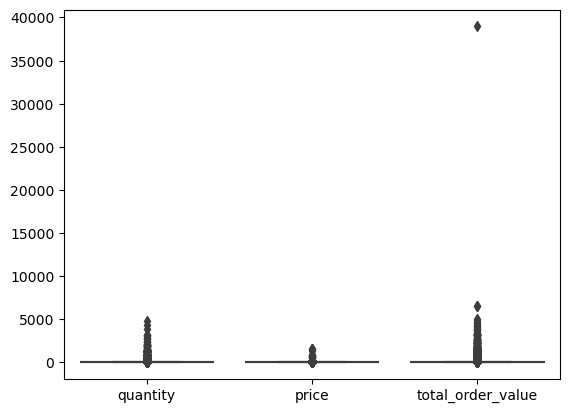

In [22]:
sns.boxplot(online_trans[["quantity", "price", "total_order_value"]]);

#### There are lots of outliers. I will take care of that during the data preparation process for the customer segmentation analysis

In [23]:
# Checking categorical variables
online_trans.describe(include=object)

,invoice,stock_code,description,customer_id,country
count,365180,365180,365180,365180,365180
unique,17553,3634,3599,4247,37
top,576339,85123A,CREAM HANGING HEART T-LIGHT HOLDER,u17841,United Kingdom
freq,542,1909,1909,7499,326124


#### From this dataset, the best seller product across all countries is "CREAM HANGING HEART T-LIGHT HOLDER" sold almost 2000 times

### Let's explore seasonality in the data

In [24]:
# Setting up monthly, yearly, daily data
online_trans['invoice_year'] = online_trans['invoice_date'].dt.year
online_trans['invoice_month'] = online_trans['invoice_date'].dt.month
online_trans['invoice_day'] = online_trans['invoice_date'].dt.day
online_trans['invoice_weekday'] = online_trans['invoice_date'].dt.dayofweek
online_trans['invoice_dayname'] = online_trans['invoice_date'].dt.day_name()

In [25]:
# Defining color palette for plots
palette = sns.color_palette("tab10")

In [26]:
# Number of invoices per month
monthly_data = online_trans.groupby(["invoice_month", "invoice_year"]).count()['invoice'].reset_index()

In [27]:
# to plot the month with the name instead of the number
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

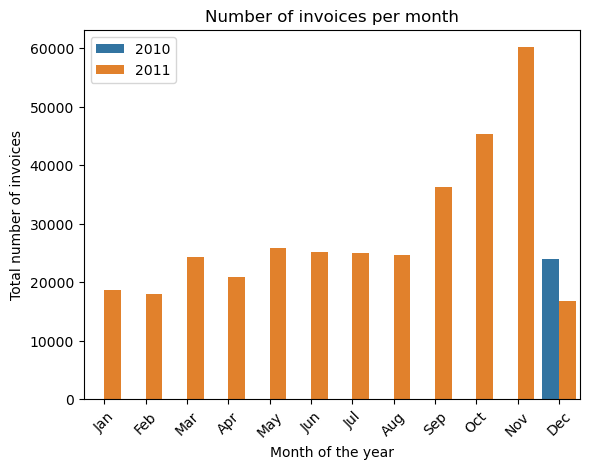

In [28]:
# Distribution of invoices per month
ax = sns.barplot(data=monthly_data, x="invoice_month", y="invoice", hue="invoice_year")
plt.title("Number of invoices per month")
plt.xlabel("Month of the year")
plt.ylabel("Total number of invoices")
ax.set_xticks(range(12))  # Set the locations of the ticks on the x-axis
ax.set_xticklabels(month_labels)  # Set the labels for the ticks
plt.xticks(rotation=45) # Rotates the ticks on the x-axis
plt.legend(loc='upper left')
plt.savefig("../visualizations/invoice_month.png")

In [29]:
# 1st and last order on the dataset
first_order = online_trans['invoice_date'].min()
last_order = online_trans['invoice_date'].max()
print(f"The first order on the dataset was purchase on {first_order} and the last one on {last_order}")

The first order on the dataset was purchase on 2010-12-01 08:26:00 and the last one on 2011-12-09 12:50:00


#### The number of invoices increases throughout the year, with a peak in November. The conclusions about December 2011 is incomplete because the dataset contains transactions till December 9th.

In [30]:
# Let's inspect the transactions on Dec 2010 and 2011 to have an estimation of the total sales on Dec 2011
Dec10_trans = online_trans[online_trans['invoice_date'] <= "2010-12-09 12:50:00"].groupby(["invoice_year", "invoice_month"]).count()['invoice'].reset_index()
Dec11_trans = online_trans[online_trans['invoice_date'] >= "2011-12-01 00:00:00"].groupby(["invoice_year", "invoice_month"]).count()['invoice'].reset_index()
Dec_comp = pd.concat([Dec10_trans, Dec11_trans])

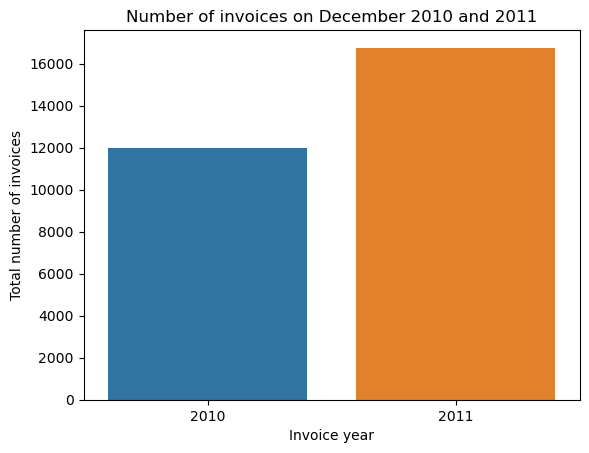

In [31]:
# Distribution of invoices on December 2010 and 2011
sns.barplot(data=Dec_comp, x='invoice_year', y='invoice')
plt.xlabel("Invoice year")
plt.ylabel("Total number of invoices")
plt.title("Number of invoices on December 2010 and 2011");

#### The last data point recorded on December 2011 was on the 9th. In the previous plot I compare the number of invoices for that same day on 2010 and 2011. Eventhough the course of the invoice on December 2011 is inconclusive, it is clear that it surpassed the number of transactions on December 9th, 2010. we can expect that on Demcember 2011 sales are gonna be above than on Demcember 2010

### Let's check seasonality on a day-week basis

In [32]:
# Checking the days of the week on he dataset 
online_trans['invoice_dayname'].unique()

array(['Wednesday', 'Thursday', 'Friday', 'Sunday', 'Monday', 'Tuesday'],
      dtype=object)

<div class="alert alert-block alert-info">
<b>Note:</b> Data for Saturday is not available in this dataset.
</div>

In [33]:
# To plot the days in order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
online_trans['invoice_dayname'] = pd.Categorical(online_trans['invoice_date'].dt.day_name(), categories=day_order, ordered=True)

In [34]:
# Getting the number of invoices per day of the week
weekly_inv = online_trans.groupby(["invoice_weekday"]).count()['invoice'].reset_index()

In [35]:
# adding the names to daily dataframe
weekly_inv['invoice_dayname'] =  day_order

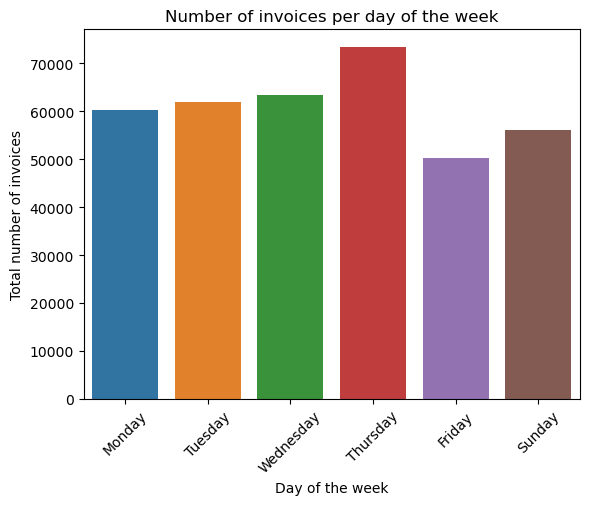

In [36]:
sns.barplot(data=weekly_inv, x='invoice_dayname', y='invoice')
plt.title("Number of invoices per day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Total number of invoices")
plt.xticks(rotation=45); # Rotates the ticks on the x-axis

### The number of invoice has a peak on Thursdays. The day with least orders is Friday

### Let's check seasonality on a day-month basis

In [37]:
daily_inv = online_trans.groupby("invoice_day").count()['invoice'].reset_index()

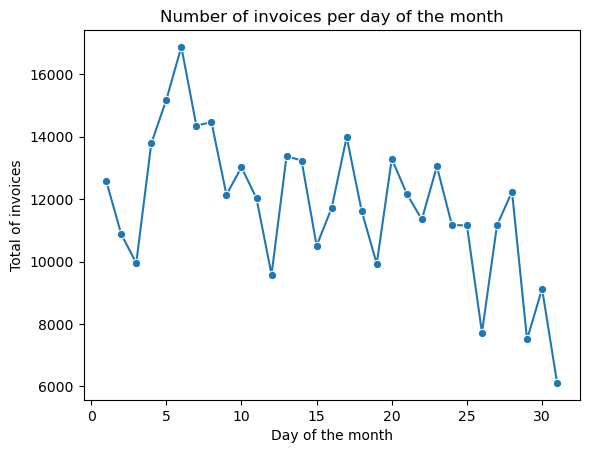

In [38]:
sns.lineplot(data=daily_inv, x='invoice_day', y='invoice', marker='o')
plt.title("Number of invoices per day of the month")
plt.xlabel("Day of the month")
plt.ylabel("Total of invoices");

#### Customers are more likely to buy on the middle of the first week of the month. From week 2 to week 3 the number of invoices keeps steady until decreasing on week 4 

## Let's explore some KPIs

In [39]:
# Line Items (Number of products per invoice)
line_items = online_trans.groupby("invoice")['stock_code'].count()
print(f"On average, there are {round(line_items.mean())} stock codes per invoice")

On average, there are 21 stock codes per invoice


In [40]:
# Average order value per invoice
avg_order = online_trans.groupby("invoice").sum()['total_order_value']
print(f"The average purchase per invoice is {round(avg_order.mean(), 2)} pounds")

The average purchase per invoice is 456.02 pounds


In [41]:
# Average order value per customer
cust_spent = online_trans.groupby("customer_id").sum()['total_order_value']
print(f"In average the customer spent {round(cust_spent.mean(),2)} pounds from December 2010 to December 2011")

In average the customer spent 1884.73 pounds from December 2010 to December 2011


In [42]:
# Number of customers who spent more than the average
cust_above_avg = (cust_spent > cust_spent.mean()).sum() 
print(f"There are {cust_above_avg} customers (out of {ot['customer_id'].nunique()}) who spent more than the average customers")

There are 866 customers (out of 4362) who spent more than the average customers


In [43]:
# Average invoices per customer
inv_cust = online_trans.groupby('customer_id').count()['invoice']
print(f"The customers made on average {round(inv_cust.mean())} purchases")

The customers made on average 86 purchases


In [44]:
# How many customers are above the average invoice per customer?
print(f"There are {(inv_cust > inv_cust.mean()).sum()} customers who made more purchases than the average")

There are 1157 customers who made more purchases than the average


### Let's explore the data grouped by customer

In [45]:
cust_data = pd.DataFrame()
cust_group = ot.groupby('customer_id')

In [46]:
# Let's define customer loyalty as the difference in time between the 1st and the last purchase
delta_date = (ot.groupby('customer_id').first()['invoice_date'] - ot.groupby('customer_id').last()['invoice_date']).abs()
cust_data['loyalty_time'] = delta_date.dt.days

In [47]:
once_cust = cust_data[cust_data['loyalty_time'] == 0].shape[0]
print(f"There are {once_cust} customer with less than 1 day of loyalty. This represent {round(once_cust *100 / cust_data.shape[0])}% of the total clients")

There are 1551 customer with less than 1 day of loyalty. This represent 36% of the total clients


In [48]:
print(f"The average loyalty time of the clients is {round(cust_data['loyalty_time'].mean())} days")

The average loyalty time of the clients is 131 days


In [49]:
# customers with loyalty time above the average
cust_above_lt = cust_data[cust_data['loyalty_time'] >= cust_data['loyalty_time'].mean()].shape[0]
print(f"The are {cust_above_lt} clients that are above the average loyalty time. This represent {round(cust_above_lt *100 / cust_data.shape[0])}% of the total clients")

The are 1957 clients that are above the average loyalty time. This represent 45% of the total clients


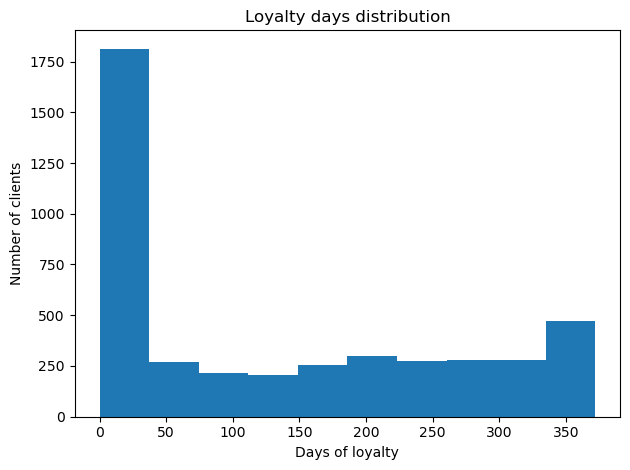

In [50]:
# Let's plot the loyalty distribution
plt.hist(cust_data['loyalty_time'])
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.savefig("../visualizations/loyalty_distribution_cust_onlyonce.png")

### Excluding the once in a life time clients the distribution of loyalty days is shown below

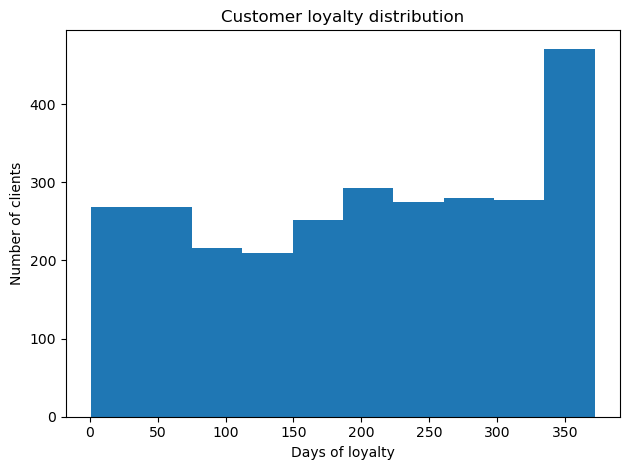

In [51]:
# Loyalty distribution excluding clients ith loyalty = 0
plt.hist(cust_data['loyalty_time'][cust_data.sort_values(by='loyalty_time', ascending=False)['loyalty_time']>0])
plt.title("Customer loyalty distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
plt.tight_layout();

### The number of clients keep constant with the number of loyalty days except those customers having almost a year of loyalty

### Let's explore the average amount of items order per customer 

In [52]:
# number of stocks per customer per invoice
nstock_inv_cust = online_trans.groupby(["customer_id", "invoice"])['stock_code'].count()

In [53]:
# average stocks ordered by customer
mean_nstock_cust = nstock_inv_cust.groupby(level=0).mean()
print(f"The average stocks per customer per invoice is {round(mean_nstock_cust.mean())}")

The average stocks per customer per invoice is 22


In [54]:
# Let's add the average stock order per invoice per customer on my customer dataset
cust_data['mean_nstock'] = mean_nstock_cust

In [55]:
cust_data.isnull().sum()

loyalty_time      0
mean_nstock     115
dtype: int64

<div class="alert alert-block alert-info">
<b>Note:</b> There are some null values corresponding to the users that returned data. At the end of the analysis these customers are gonna be dropped
</div>

In [56]:
cust_data

,loyalty_time,mean_nstock
customer_id,,
u12346,0,NaN
u12347,365,26.000000
u12348,282,6.750000
u12349,0,72.000000
u1235,0,16.000000
...,...,...
u1828,0,10.000000
u18281,0,7.000000
u18282,114,6.000000


### Now explore the amount of items purchased by customer by invoice. This will represent the quantity of the previous stocks per invoice per client

In [57]:
# Amount of items order per invoice by customer
nitem_inv_cust = online_trans.groupby(["customer_id", "invoice"])['quantity'].sum()

In [58]:
# Average amount of items order by customer
mean_nitem_cust = nitem_inv_cust.groupby(level=0).mean()
print(f"The average items per customer per invoice is {round(mean_nitem_cust.mean())}")

The average items per customer per invoice is 225


In [59]:
# Let's add the average amount of items per invoice per customer on my customer dataset
cust_data['mean_nitem'] = mean_nitem_cust

In [60]:
# Frequency is the total transactions that they purchased

<div class="alert alert-block alert-info">
<b>TO DO!:</b> For the top 5 customers/products check the purchases on time.
</div>

In [61]:
# Let's check what was the avergage total order value (tov) per client
tov_inv_cust = online_trans.groupby(["customer_id", "invoice"])['total_order_value'].sum()

In [62]:
mean_tov_cust = tov_inv_cust.groupby(level=0).mean()
print(f"The average total order value per customer per invoice is {round(mean_tov_cust.mean())} pounds")

The average total order value per customer per invoice is 371 pounds


In [63]:
# The sum of the total order value per customer is gonna define the monetary value
cust_data['mon_value'] = online_trans.groupby(["customer_id"])['total_order_value'].sum()

In [64]:
# Let's define the frequency as the total number of invoices per customer
cust_data['frequency'] = online_trans.groupby(["customer_id"]).count()['invoice']

In [65]:
# Let's calculate the recency. As the data is from 2011 I will consider recency as the difference between the last day
# the customer order and the day after of the last purchase from the whole dataset
cust_data['recency'] = (online_trans['invoice_date'].max() - cust_group['invoice_date'].max()).dt.days

In [66]:
print(f"There are {cust_data.isna().sum()[1]} null entries. They represent the customers that were deleted due to returned transactions. Let's drop them!")

There are 115 null entries. They represent the customers that were deleted due to returned transactions. Let's drop them!


In [67]:
cust_data.dropna(inplace=True)
cust_data.reset_index()

,customer_id,loyalty_time,mean_nstock,mean_nitem,mon_value,frequency,recency
0,u12347,365,26.000000,351.142857,4310.00,182.0,1
1,u12348,282,6.750000,583.000000,1437.24,27.0,74
2,u12349,0,72.000000,630.000000,1457.55,72.0,18
3,u1235,0,16.000000,196.000000,294.40,16.0,309
4,u12352,260,11.000000,75.142857,1385.74,77.0,35
...,...,...,...,...,...,...,...
4242,u1828,0,10.000000,45.000000,180.60,10.0,277
4243,u18281,0,7.000000,54.000000,80.82,7.0,180
4244,u18282,114,6.000000,51.500000,178.05,12.0,7
4245,u18283,333,44.937500,84.687500,2039.58,719.0,3


In [68]:
cust_data.describe()

,loyalty_time,mean_nstock,mean_nitem,mon_value,frequency,recency
count,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000
mean,133.676948,21.560731,224.903868,1884.727573,85.985401,88.463386
std,132.639094,19.285931,305.002619,8210.321624,215.913912,98.735861
min,0.000000,1.000000,1.000000,0.850000,1.000000,0.000000
25%,0.000000,9.041667,90.583333,297.200000,16.000000,15.500000
50%,101.000000,16.500000,158.235294,635.680000,39.000000,46.000000
75%,257.000000,28.000000,265.483333,1534.090000,94.000000,134.000000
max,372.000000,300.647059,7824.000000,279138.020000,7499.000000,373.000000


In [69]:
# Let's save the data as csv file to use it on the next notebook ;)
cust_data.to_csv("../data/customer_data.csv")